### State of the Climate Report for 2023 

This analysis is for the heat fluxes part of the Southern Ocean section of the report.

Lead Author of the Southern Ocean section: Sandy Thomalla (Southern Ocean Carbon and Climate Observatory)

Data analysis: Marcel du Plessis (University of Gothenburg)

ERA5 data downloaded from: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=form 

In [1]:
# load functions

import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import pandas as pd

from glob import glob

from functions.map_plotting import southern_ocean_map

from functions.adjust_lon_xr_dataset import adjust_lon_xr_dataset


In [2]:
# load the 2023 era5 heat fluxes

# read in the monthly era5 data downloaded from the copernicus climate data store. The climatology is between 1991 and 2020 as defined by the WMO

ds_2023 = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/reanalysis/era5/2023_MONTHLY_SSHF_SLHF_SSR_STR.nc')
ds_clim = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/reanalysis/era5/1991_2020_MONTHLY_SSHF_SLHF_SSR_STR.nc')

In [3]:
# convert the era5 fluxes from J/m2 to W/m2

# era5 heat flux data is provided in J/m2, so to convert this, we divide by the number of seconds in a day

seconds_in_day = 3600*24

vars = ['slhf', 'sshf', 'str', 'ssr']

for var in vars:

    print(var)

    ds_clim[var] = (('time', 'latitude', 'longitude'), ds_clim[var].data/seconds_in_day)
    ds_2023[var] = (('time', 'latitude', 'longitude'), ds_2023[var].data/seconds_in_day)

slhf
sshf
str
ssr


In [4]:
# calculate the net flux

# sum the terms to get to the net heat flux

ds_clim['qnet'] = (('time', 'latitude', 'longitude'), ds_clim.ssr.data + ds_clim.str.data + ds_clim.sshf.data + ds_clim.slhf.data)
ds_2023['qnet'] = (('time', 'latitude', 'longitude'), ds_2023.ssr.data + ds_2023.str.data + ds_2023.sshf.data + ds_2023.slhf.data)

In [5]:
# choose everything south of 30

ds_clim = ds_clim.sel(latitude=slice(-30, -90))
ds_2023 = ds_2023.sel(latitude=slice(-30, -90))

In [6]:
# create monthly means

ds_clim_mean = ds_clim.groupby('time.month').mean('time')
ds_clim_stde = ds_clim.groupby('time.month').std('time')

ds_2023 = ds_2023.groupby('time.month').mean('time')

In [7]:
# calculate the standard error of the mean by diving the standard deviation by the sqrt of the number of years

# this is dividing the standard deviation of all the years for a particular month, say for example January, and then dividing by the 29 years that make up the climatology

for v in ds_clim_stde.variables:

    print(v)

    if str(v) == 'latitude' or str(v) == 'longitude' or str(v) == 'month':
        continue

    else:
        ds_clim_stde[v] = (('month', 'latitude', 'longitude'), ds_clim_stde[v].data/np.sqrt(29))

longitude
latitude
slhf
ssr
str
sshf
qnet
month


In [8]:
# load the data to memory

ds_2023 = ds_2023.load()
ds_clim_stdv = ds_clim_stde.load()
ds_clim_mean = ds_clim_mean.load()

In [9]:
# load the land sea mask and remove the data the falls over land

lsm = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/reanalysis/era5/land_sea_mask.nc')

lsm = lsm.sel(latitude=slice(-30, -90), time='2018-12-19')

lsm = adjust_lon_xr_dataset(lsm)

In [10]:
# remove land fluxes

ds_clim_mean = ds_clim_mean.where(lsm.lsm.data == 0)
ds_clim_stde = ds_clim_stde.where(lsm.lsm.data == 0)
ds_2023 = ds_2023.where(lsm.lsm.data == 0)

In [11]:
# calculate the anomaly

ds_anom = ds_2023 - ds_clim_mean

Text(0.5, 1.0, '2023')

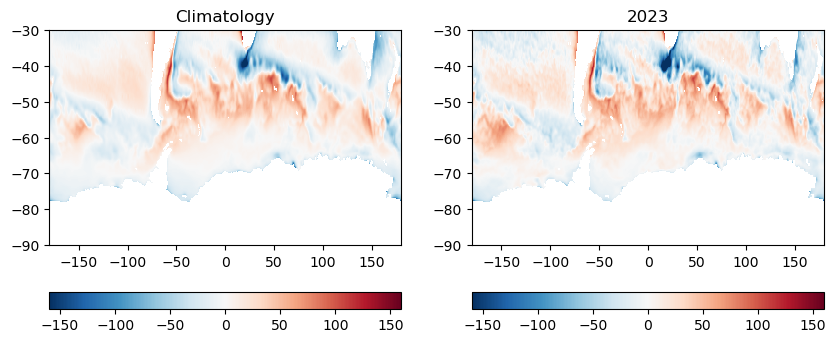

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

props = dict(cmap='RdBu_r', vmin=-160, vmax=160)

img0 = ax[0].pcolormesh(ds_clim_mean.longitude, ds_clim_mean.latitude, ds_clim_mean.qnet.mean(dim='month'), **props)
img1 = ax[1].pcolormesh(ds_2023.longitude, ds_2023.latitude, ds_2023.qnet.mean(dim='month'), **props)

plt.colorbar(img0, ax=ax[0], orientation='horizontal')
plt.colorbar(img1, ax=ax[1], orientation='horizontal')

ax[0].set_title('Climatology')
ax[1].set_title('2023')

In [13]:
import pandas as pd

# Read the CSV file into a DataFrame
saf = pd.read_csv('/Users/xduplm/Google Drive/My Drive/Data/Fronts/orsi_1995/saf.txt', sep='\t')

# Check where the condition is True ('X')
true_locations = saf.where(saf == 'X').stack()

# Print the locations
print(true_locations)

saf = saf.iloc[:1080]

1080  X    X
dtype: object


In [14]:
import pandas as pd

# Read the CSV file into a DataFrame
saccf = pd.read_csv('/Users/xduplm/Google Drive/My Drive/Data/Fronts/orsi_1995/saccf.txt', sep='\t')

# Check where the condition is True ('X')
true_locations = saccf.where(saccf == 'X').stack()

# Print the locations
print(true_locations)

saccf = saccf.iloc[:912]

912  X    X
998  X    X
dtype: object


In [15]:
# load saf 

lon_saf = np.ndarray([saf.size])
lat_saf = np.ndarray([saf.size])

for i in range(saf.size):
    
    lon_saf[i] = saf.iloc[i][0][:10]
    lat_saf[i] = saf.iloc[i][0][10:]

/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_35094/89803231.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lon_saf[i] = saf.iloc[i][0][:10]
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_35094/89803231.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lat_saf[i] = saf.iloc[i][0][10:]


In [16]:
# load saccf

lon_saccf = np.ndarray([saccf.size])
lat_saccf = np.ndarray([saccf.size])

for i in range(saccf.size):
        
    lon_saccf[i] = saccf.iloc[i][0][:10]
    lat_saccf[i] = saccf.iloc[i][0][10:]

/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_35094/1753088276.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lon_saccf[i] = saccf.iloc[i][0][:10]
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_35094/1753088276.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lat_saccf[i] = saccf.iloc[i][0][10:]


In [17]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# create a function to add gridlines and labels to cartopy plots

import matplotlib.ticker as mticker

from functions.map_plotting import gridlines

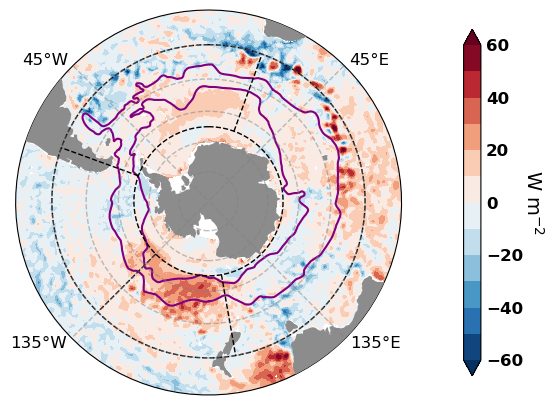

In [19]:
# plot the net heat flux anomaly 2023 - climatology

props = dict(cmap='RdBu_r', levels=np.arange(-60, 70, 10), extend='both')

fig = plt.figure(figsize=[8, 5])

ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND, zorder=90, edgecolor='black', color='0.55')
# ax.add_feature(cfeature.COASTLINE, zorder=100, linewidth=0.25)

gl = gridlines(ax)

img = ax.contourf(ds_anom.longitude, ds_anom.latitude, ds_anom.qnet.mean(dim='month'), **props, transform=ccrs.PlateCarree())

cb = plt.colorbar(img, ax=ax, orientation='vertical', shrink=0.9, pad=0.1)

cb.ax.tick_params(length=0, labelsize=12)
cb.set_label('W m$^{-2}$', rotation=-90, labelpad=15, fontsize=14)

# Get the tick labels and set font weight to bold
tick_labels = cb.ax.get_yticklabels()
for label in tick_labels:
    label.set_weight('bold')

ring_lon = np.linspace(0, 360, 360)
small_ring_lat = np.ones(360)* -65
large_ring_lat = np.ones(360)* -40

ax.plot([-70, -70], [-65, -40], c='k', ls='--', transform=ccrs.PlateCarree(), lw=1, zorder=100)
ax.plot([ 20,  20], [-65, -40], c='k', ls='--', transform=ccrs.PlateCarree(), lw=1, zorder=100)
ax.plot([170, 170], [-65, -40], c='k', ls='--', transform=ccrs.PlateCarree(), lw=1, zorder=100)
ax.plot([-135, -135], [-65, -40], c='k', ls='--', transform=ccrs.PlateCarree(), lw=1, zorder=100)

ax.plot(ring_lon, small_ring_lat, c='k', ls='--', transform=ccrs.PlateCarree(), lw=1, zorder=100)
ax.plot(ring_lon, large_ring_lat, c='k', ls='--', transform=ccrs.PlateCarree(), lw=1, zorder=100)

ax.plot(lon_saf, lat_saf, c='purple', lw=1.5, transform=ccrs.PlateCarree(), zorder=10)
ax.plot(lon_saccf, lat_saccf, c='purple', lw=1.5, transform=ccrs.PlateCarree(), zorder=10)

# ax.set_title('Net heat flux anomaly', fontweight='bold', pad=10)

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2024_soc_heat_flux/map.png', dpi=500)


In [33]:
# now we choose the sectors

# southern ocean

so_lat_min = -65
so_lat_max = -40

ds_anom_so = ds_anom.sel(latitude=slice(so_lat_max, so_lat_min))

ds_anom_atl = ds_anom.sel(latitude=slice(so_lat_max, so_lat_min), longitude=slice(-70, 20)) # atlantic
ds_anom_epc = ds_anom.sel(latitude=slice(so_lat_max, so_lat_min), longitude=slice(-135, -70)) # eastern pacific
ds_anom_ind = ds_anom.sel(latitude=slice(so_lat_max, so_lat_min), longitude=slice(20, 170)) # indian

ds_anom_wpc1 = ds_anom.sel(latitude=slice(so_lat_max, so_lat_min), longitude=slice(-180, -135)) # western pacific 1
ds_anom_wpc2 = ds_anom.sel(latitude=slice(so_lat_max, so_lat_min), longitude=slice(170, 180)) # western pacific 2

# combine the two western pacifics

ds_anom_wpc1['longitude'] = ds_anom_wpc1['longitude'] + 360

ds_anom_wpc = xr.concat([ds_anom_wpc2, ds_anom_wpc1], dim='longitude')

# 

In [32]:
# find the std err of the sectors to plot as the uncertainties

ds_clim_stde_so = ds_clim_stde.sel(latitude=slice(so_lat_max, so_lat_min))

ds_clim_stde_atl = ds_clim_stde.sel(latitude=slice(so_lat_max, so_lat_min), longitude=slice(-70, 20))
ds_clim_stde_epc = ds_clim_stde.sel(latitude=slice(so_lat_max, so_lat_min), longitude=slice(-135, -70))
ds_clim_stde_ind = ds_clim_stde.sel(latitude=slice(so_lat_max, so_lat_min), longitude=slice(20, 170))

ds_clim_stde_wpc1 = ds_clim_stde.sel(latitude=slice(so_lat_max, so_lat_min), longitude=slice(-180, -135))
ds_clim_stde_wpc2 = ds_clim_stde.sel(latitude=slice(so_lat_max, so_lat_min), longitude=slice(170, 180))

ds_clim_stde_wpc1['longitude'] = ds_clim_stde_wpc1['longitude'] + 360

ds_clim_stde_wpc = xr.concat([ds_clim_stde_wpc2, ds_clim_stde_wpc1], dim='longitude')

In [38]:
# weighted means

# western pacific

weights_wpc = np.cos(np.deg2rad(ds_anom_wpc.latitude))
weights_wpc.name = "weights"

ds_anom_wpc_weighted_mean = ds_anom_wpc.weighted(weights_wpc).mean(("longitude", "latitude"))
ds_anom_wpc_standard_error = ds_clim_stde_wpc.weighted(weights_wpc).mean(("longitude", "latitude"))

# eastern pacific

weights_epc = np.cos(np.deg2rad(ds_anom_epc.latitude))
weights_epc.name = "weights"

ds_anom_epc_weighted_mean = ds_anom_epc.weighted(weights_epc).mean(("longitude", "latitude"))
ds_anom_epc_standard_error = ds_clim_stde_epc.weighted(weights_epc).mean(("longitude", "latitude"))

# atlantic

weights_atl = np.cos(np.deg2rad(ds_anom_atl.latitude))
weights_atl.name = "weights"

ds_anom_atl_weighted_mean = ds_anom_atl.weighted(weights_atl).mean(("longitude", "latitude"))
ds_anom_atl_standard_error = ds_clim_stde_atl.weighted(weights_atl).mean(("longitude", "latitude"))

# indian

weights_ind = np.cos(np.deg2rad(ds_anom_ind.latitude))
weights_ind.name = "weights"

ds_anom_ind_weighted_mean = ds_anom_ind.weighted(weights_ind).mean(("longitude", "latitude"))
ds_anom_ind_standard_error = ds_clim_stde_ind.weighted(weights_ind).mean(("longitude", "latitude"))

# southern ocean

weights_so = np.cos(np.deg2rad(ds_anom_so.latitude))
weights_so.name = "weights"

ds_anom_so_weighted_mean = ds_anom_so.weighted(weights_so).mean(("longitude", "latitude"))
ds_anom_so_standard_error = ds_clim_stde_so.weighted(weights_so).mean(("longitude", "latitude"))

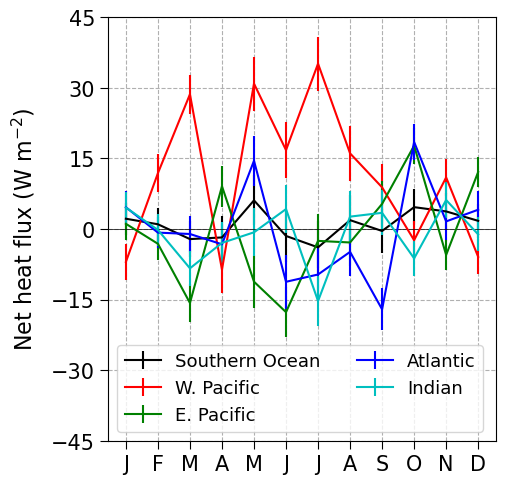

In [41]:
fig, ax = plt.subplots(figsize=(5, 5.5))

ax.errorbar(x=ds_anom_so.month,  y=ds_anom_so_weighted_mean.qnet,  yerr=ds_anom_so_standard_error.qnet,  c='k', lw=1.5, label='Southern Ocean')
ax.errorbar(x=ds_anom_wpc.month, y=ds_anom_wpc_weighted_mean.qnet, yerr=ds_anom_wpc_standard_error.qnet, c='r', lw=1.5, label='W. Pacific')
ax.errorbar(x=ds_anom_epc.month, y=ds_anom_epc_weighted_mean.qnet, yerr=ds_anom_epc_standard_error.qnet, c='g', lw=1.5, label='E. Pacific')
ax.errorbar(x=ds_anom_atl.month, y=ds_anom_atl_weighted_mean.qnet, yerr=ds_anom_atl_standard_error.qnet, c='b', lw=1.5, label='Atlantic')
ax.errorbar(x=ds_anom_ind.month, y=ds_anom_ind_weighted_mean.qnet, yerr=ds_anom_ind_standard_error.qnet, c='c', lw=1.5, label='Indian')

ax.legend(loc=3, ncol=2, fontsize=13)

ax.grid(ls='--')

ax.set_ylim(-45, 45)

months = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

ax.xaxis.set_ticks(np.arange(1, 13))

ax.xaxis.set_ticklabels(months)

ax.axhline(lw=0.5, c='k')

ax.set_ylabel('Net heat flux (W m$^{-2}$)', fontsize=16, labelpad=10)

plt.tick_params(axis='both', which='major', labelsize=15)

ax.yaxis.set_ticks(np.arange(-45, 60, 15))

plt.tick_params(axis='both', which='major', length=6)

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2024_soc_heat_flux/annual_cycle.png', dpi=500)

